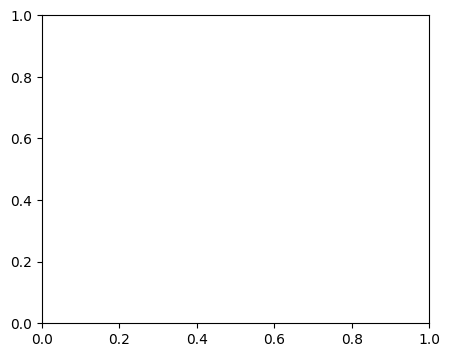

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import ttk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# Generate synthetic regression data
np.random.seed(42)
X = np.linspace(-5, 5, 100).reshape(-1, 1)
y = np.sin(X) + 0.1 * np.random.randn(100, 1)  # y = sin(X) with noise

# Neural Network Layer
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)

# Activation Function
class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

# Mean Squared Error (MSE) Loss
class Loss_MSE:
    def forward(self, y_pred, y_true):
        return np.mean((y_true - y_pred) ** 2)

    def backward(self, y_pred, y_true):
        self.dinputs = -2 * (y_true - y_pred) / len(y_true)

# Optimizers
class Optimizer_SGD:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate

    def update_params(self, layer):
        layer.weights -= self.learning_rate * layer.dweights
        layer.biases -= self.learning_rate * layer.dbiases

class Optimizer_Momentum:
    def __init__(self, learning_rate=0.01, momentum=0.9):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.velocity_w = None
        self.velocity_b = None

    def update_params(self, layer):
        if self.velocity_w is None:
            self.velocity_w = np.zeros_like(layer.weights)
            self.velocity_b = np.zeros_like(layer.biases)
        
        self.velocity_w = self.momentum * self.velocity_w - self.learning_rate * layer.dweights
        self.velocity_b = self.momentum * self.velocity_b - self.learning_rate * layer.dbiases
        
        layer.weights += self.velocity_w
        layer.biases += self.velocity_b

# GUI Setup
def train_and_plot():
    optimizer_choice = optimizer_var.get()
    learning_rate = float(lr_entry.get())
    
    # Choose optimizer
    if optimizer_choice == "SGD":
        optimizer = Optimizer_SGD(learning_rate)
    elif optimizer_choice == "Momentum":
        optimizer = Optimizer_Momentum(learning_rate)
    else:
        return
    
    # Initialize network
    dense1 = Layer_Dense(1, 64)
    activation1 = Activation_ReLU()
    dense2 = Layer_Dense(64, 1)
    loss_function = Loss_MSE()
    
    losses = []
    for epoch in range(1000):
        dense1.forward(X)
        activation1.forward(dense1.output)
        dense2.forward(activation1.output)
        
        loss = loss_function.forward(dense2.output, y)
        losses.append(loss)
        
        loss_function.backward(dense2.output, y)
        dense2.backward(loss_function.dinputs)
        activation1.backward(dense2.dinputs)
        dense1.backward(activation1.dinputs)
        
        optimizer.update_params(dense1)
        optimizer.update_params(dense2)
        
    ax.clear()
    ax.plot(losses, label=f'{optimizer_choice} Loss')
    ax.legend()
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    canvas.draw()

# Tkinter UI
root = tk.Tk()
root.title("Neural Network Optimizer Comparison")

frame = tk.Frame(root)
frame.pack(pady=20)

tk.Label(frame, text="Select Optimizer:").grid(row=0, column=0)
optimizer_var = tk.StringVar(value="SGD")
optimizers = ["SGD", "Momentum"]
optimizer_menu = ttk.Combobox(frame, textvariable=optimizer_var, values=optimizers)
optimizer_menu.grid(row=0, column=1)

tk.Label(frame, text="Learning Rate:").grid(row=1, column=0)
lr_entry = tk.Entry(frame)
lr_entry.grid(row=1, column=1)
lr_entry.insert(0, "0.01")

train_button = tk.Button(frame, text="Train", command=train_and_plot)
train_button.grid(row=2, columnspan=2, pady=10)

fig, ax = plt.subplots(figsize=(5, 4))
canvas = FigureCanvasTkAgg(fig, master=root)
canvas.get_tk_widget().pack()

root.mainloop()
